In [1]:
from src.utils import data_load
import pandas as pd
from src.s3_utils import pandas_from_csv_s3
import re

# Data processing: Join PHQ9, GAD7 and ACE datasets together by record_id and redcap_event_name

In [2]:
data = data_load(data_keys={'phq9', 'generalized_anxiety_disorder_scale_gad7', 'ace', 'surveys', 'study_ids', 'check_in_adherence_log'})

In [3]:
outcomes = pd.merge(data['phq9'], data['generalized_anxiety_disorder_scale_gad7'],  how='outer', left_on=['record_id','redcap_event_name'], right_on = ['record_id','redcap_event_name'])

In [4]:
overall_df = pd.merge(data['ace'].drop(columns=['redcap_event_name']).dropna(), outcomes, how='left', on='record_id')

In [25]:
import numpy as np
count = {'negative': 0, 'positive': 0}
phq9 = data['phq9'].dropna()
for rid in phq9['record_id'].unique():
    each_data = phq9[phq9['record_id'] == rid]
    # print(each_data['phq9_9'].to_numpy())
    print(each_data['phq9_9'].to_numpy().astype(np.int))
    if 1 in each_data['phq9_9'].to_numpy().astype(np.int):
        count['positive'] += 1
    else:
        count['negative'] += 1

[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0]
[0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 1]
[0 0 0 1 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0]
[0]
[0 0]
[0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [22]:
count

{'negative': 410, 'positive': 16}

# Convert redcap_event_name to date for PHQ9, GAD7 and ACE datasets

In [5]:
# read study ids
id_df = data['study_ids'][['record_id', 'evidation_id']]
id_df.rename(columns={'evidation_id': 'user_id'}, inplace=True)

# add ids to survey
overall_df = overall_df.merge(id_df, on=['record_id'])
overall_df.user_id = overall_df.user_id.fillna(-1).astype(int)

# standarize naming convention for easier processing later on
overall_df.redcap_event_name = overall_df.redcap_event_name.replace('postnatal_checkin_arm_1','postnatal_ci_1_arm_1')

In [6]:
# read check-in dates
ci_df = data['check_in_adherence_log']
cols = ['record_id'] + [col for col in ci_df.columns if '_date' in col]
ci_df = ci_df[cols]

# standarize naming convention for easier processing later on
ci_df = ci_df.rename(columns={'checkin_postnatal_date': 'checkin_postnatal_date_1'})

# add dates to survey, need to map it using the check_in_adherence_log
def conver_checkin_string(x):
    x = x.split('_arm')[0] #delete all characters after the word 'arm'
    num = int(re.search(r'\d+', x).group())
    if 'postnatal' in x:
        return f'checkin_postnatal_date_{num}'
    else:
        return f'checkin_{num}_date'

# map checkin_postnature_date_{num} OR checkin_{num}_date to the actual date
def map_date(x):
    checkin_string_col = x['checkin_string']
    return x[checkin_string_col]

overall_df = overall_df.merge(ci_df, on=['record_id'])
overall_df['checkin_string'] = overall_df.redcap_event_name.apply(conver_checkin_string)
overall_df['date'] = overall_df.apply(map_date, axis=1)
overall_df = overall_df[overall_df.columns.drop(list(overall_df.filter(regex='checkin_')))]
overall_df['date'] = pd.to_datetime(overall_df['date'])

In [7]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)
overall_df.loc[overall_df['record_id'] == 28][['date', 'redcap_event_name']] #check if dates are correctly processed

,date,redcap_event_name
203,2021-04-30,ci_1_arm_1
204,2021-05-11,ci_2_arm_1
205,2021-05-25,ci_3_arm_1
206,2021-06-08,ci_4_arm_1
207,2021-06-22,ci_5_arm_1
208,2021-08-02,ci_8_arm_1
209,2021-08-17,ci_9_arm_1
210,2021-09-07,ci_10_arm_1
211,2021-10-01,postnatal_ci_1_arm_1
212,2021-10-26,postnatal_ci_2_arm_1


# Add Global survey data - PROMIS quality of life

In [8]:
answer_dict0 = {
    0: 4,
    1: 3,
    2: 3,
    4: 2,
    5: 2,
    6: 2,
    7: 1,
    8: 1,
    9: 1,
    10: 0
}
answer_dict1 = {
    'Excellent': 4,
    'Very good': 3,
    'Good': 2,
    'Fair': 1,
    'Poor': 0
}
answer_dict2 = {
    'Completely': 4,
    'Mostly': 3,
    'Moderately': 2,
    'A little': 1,
    'Not at all': 0
}
answer_dict3 = {
    'Never': 4,
    'Rarely': 3,
    'Sometimes': 2,
    'Often': 2,
    'Always': 0
}
answer_dict4 = {
    'None': 4,
    'Mild': 3,
    'Moderate': 2,
    'Severe': 1,
    'Very severe': 0
}
# question 119 and 114 are not used in Global Physical Health and Global Mental Health. Refer to the BUMP data dictionary excel sheet
drop_question_ids = [114, 119]
promis_survey = data['surveys'].loc[data['surveys']['title']=='Global survey']
promis_survey.drop(promis_survey[promis_survey['question_id'].isin(drop_question_ids)].index, inplace=True)
for qid in promis_survey['question_id'].unique():
    question = promis_survey.loc[promis_survey['question_id'] == qid]
    if qid == 123:
        question['answer_text'] = question['answer_text'].astype(int)
        question.replace({"answer_text": answer_dict0}, inplace=True)
    elif qid in {115, 116, 117, 118}:
        question.replace({"answer_text": answer_dict1}, inplace=True)
    elif qid == 120:
        question.replace({"answer_text": answer_dict2}, inplace=True)
    elif qid == 121:
        question.replace({"answer_text": answer_dict3}, inplace=True)
    elif qid == 122:
        question.replace({"answer_text": answer_dict4}, inplace=True)
    promis_survey.loc[promis_survey['question_id'] == qid] = question
promis_survey['date'] = pd.to_datetime(promis_survey['date'])

In [9]:
promis_survey.head()

,id,user_id,survey_id,title,event_date,from,to,created_at,updated_at,question_id,question_text,answer_text,date
0,1598695,2160,11,Global survey,2022-06-15 00:00:00,2022-06-15 05:00:00,2022-06-16 04:00:00,2022-06-15 04:29:34.002629,2022-06-15 14:54:00.989426,123,In the past 7 days:\r\n\r\nHow would you rate your pain on average?,4,2022-06-15
1,1598693,2038,11,Global survey,2022-06-15 00:00:00,2022-06-15 05:00:00,2022-06-16 04:00:00,2022-06-15 04:29:32.154151,2022-06-15 16:53:41.712904,123,In the past 7 days:\r\n\r\nHow would you rate your pain on average?,4,2022-06-15
4,1594549,190,11,Global survey,2022-06-15 00:00:00,2022-06-14 05:00:00,2022-06-15 04:00:00,2022-06-14 05:28:01.57594,2022-06-15 01:58:49.913336,123,In the past 7 days:\r\n\r\nHow would you rate your pain on average?,4,2022-06-15
5,1589873,1032,11,Global survey,2022-06-13 00:00:00,2022-06-13 06:00:00,2022-06-14 05:00:00,2022-06-13 06:30:20.323898,2022-06-13 16:58:08.632105,123,In the past 7 days:\r\n\r\nHow would you rate your pain on average?,4,2022-06-13
6,1604557,2166,11,Global survey,2022-06-17 00:00:00,2022-06-16 05:00:00,2022-06-17 04:00:00,2022-06-16 04:26:11.000158,2022-06-17 01:01:11.174852,123,In the past 7 days:\r\n\r\nHow would you rate your pain on average?,4,2022-06-17


In [10]:
promis_mental_lst = [f'promis_global10_mental_{x}' for x in range(1,5)]
promis_physical_lst = [f'promis_global10_physical_{x}' for x in range(1,5)]
mental_health_question_ids = [115, 117, 118, 121]
physical_health_question_ids = [116, 120, 122, 123]
promis_survey_processed = pd.DataFrame(columns=['user_id', 'date'] + promis_mental_lst + promis_physical_lst)

for uid in promis_survey['user_id'].unique():
    each_user_survey = promis_survey.loc[promis_survey['user_id'] == uid]
    for date in each_user_survey['date'].unique():
        # answer_text = each_user_survey.loc[each_user_survey['date'] == date].sort_values(by='question_id')['answer_text'].to_numpy()
        each_date_survey = each_user_survey.loc[each_user_survey['date'] == date]
        mental_health_answers = each_date_survey[each_date_survey['question_id'].isin(mental_health_question_ids)].sort_values(by='question_id')['answer_text']
        physical_health_answers = each_date_survey[each_date_survey['question_id'].isin(physical_health_question_ids)].sort_values(by='question_id')['answer_text']
        if len(mental_health_answers) == 4 and len(physical_health_answers) == 4:
            promis_survey_processed = promis_survey_processed.append(pd.DataFrame([[uid, date] + mental_health_answers.tolist() + physical_health_answers.tolist()], columns=['user_id', 'date'] + promis_mental_lst + promis_physical_lst), ignore_index = True)

# Process PHQ9, GAD and PROMIS data by taking the average over time for each individual

In [11]:
# from literature
ace_levels = {
    (0, 4) : 0,
    (5, 10): 1
}
phq9_levels = {
    (0, 4) : 0,
    (5, 9): 1,
    (10, 14): 2,
    (15, 19): 3,
    (20, 27): 4
}
gad_levels = {
    (0, 4) : 0,
    (5, 9): 1,
    (10, 14): 2,
    (15, 21): 3
}
promis_mental_levels = {
    (0, 11) : 0,
    (12, 16): 1,
}
promis_physical_levels = {
    (0, 10) : 0,
    (11, 16): 1,
}
def map_levels(x, map_dict):
    for key in map_dict:
        if isinstance(x, str):
            if x == key:
                return map_dict[key]
        else:
            if x >= key[0] and x <= key[1]:
                return map_dict[key]

In [12]:
processed_overall_df = pd.DataFrame(columns=['user_id', 'ace_sum', 'phq9_sum', 'gad_sum', 'promis_mental_mean', 'promis_physical_mean'])
ace_lst = [f'ace_{x}' for x in range(1,11)]
phq9_lst = [f'phq9_{x}' for x in range(1,11)]
gad_lst = [f'gad_{x}' for x in range(1,9)]
for uid in overall_df['user_id'].unique():
    each_df = overall_df.loc[overall_df['user_id']==uid]
    ace_sum = each_df[ace_lst].sum(axis=1)
    ace_sum_mean = ace_sum.apply(map_levels, map_dict=ace_levels).mean()

    phq9_sum = each_df[phq9_lst].sum(axis=1)
    phq9_sum_mean = phq9_sum.apply(map_levels, map_dict=phq9_levels).mean()

    gad_sum = each_df[gad_lst].sum(axis=1)
    gad_sum_mean = gad_sum.apply(map_levels, map_dict=gad_levels).mean()

    promis_mental_sum = promis_survey_processed.loc[promis_survey_processed['user_id']==uid][promis_mental_lst].sum(axis=1)
    promis_mental_mean = promis_mental_sum.apply(map_levels, map_dict=promis_mental_levels).mean()

    promis_physical_sum = promis_survey_processed.loc[promis_survey_processed['user_id']==uid][promis_physical_lst].sum(axis=1)
    promis_physical_mean = promis_physical_sum.apply(map_levels, map_dict=promis_physical_levels).mean()
    
    processed_overall_df = processed_overall_df.append({'user_id': uid, 'ace_sum': ace_sum_mean, 'promis_physical_mean': promis_physical_mean, 'promis_mental_mean': promis_mental_mean, 'phq9_sum': phq9_sum_mean, 'gad_sum': gad_sum_mean}, ignore_index=True)

In [13]:
processed_overall_df = processed_overall_df.dropna()

In [15]:
# processed_overall_df.to_csv('processed_causal_ace_4nodes_ref_levels_reverse.csv', index=False)

In [16]:
# processed_overall_df[['phq9_sum', 'gad_sum', 'promis_mean']] = processed_overall_df[['phq9_sum', 'gad_sum', 'promis_mean']] * 5

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-e5jtcir2 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<AxesSubplot:>

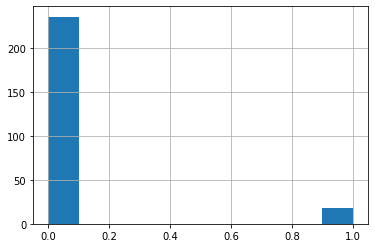

In [14]:
processed_overall_df['ace_sum'].hist()

<AxesSubplot:>

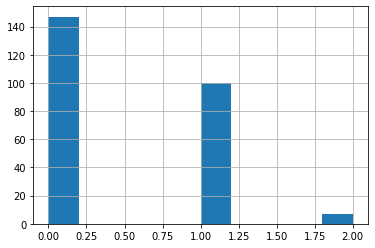

In [15]:
processed_overall_df['phq9_sum'].round().hist()

<AxesSubplot:>

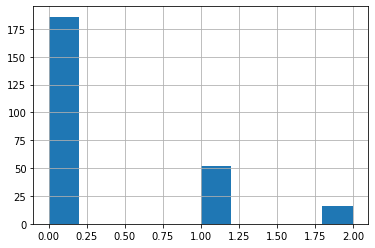

In [16]:
processed_overall_df['gad_sum'].round().hist()

<AxesSubplot:>

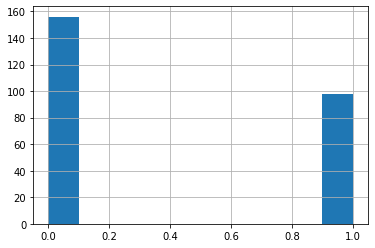

In [17]:
processed_overall_df['promis_mental_mean'].round().hist()

<AxesSubplot:>

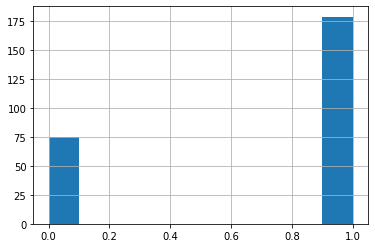

In [18]:
processed_overall_df['promis_physical_mean'].round().hist()

In [14]:
processed_overall_df.head()

,user_id,ace_sum,phq9_sum,gad_sum,promis_mental_mean,promis_physical_mean
0,28.0,1.0,1.000000,1.357143,0.00,0.777778
1,29.0,0.0,1.384615,1.615385,0.00,0.571429
2,30.0,0.0,0.083333,0.333333,0.00,1.000000
3,31.0,0.0,1.333333,2.333333,0.00,0.000000
5,37.0,0.0,0.916667,0.500000,0.25,0.750000


In [18]:
import networkx
import notears.notears as notears
import matplotlib.pyplot as plt


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-c_gzpg7q because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [12]:
feature_list = ['ace_sum', 'phq9_sum', 'gad_sum', 'promis_mental_mean', 'promis_physical_mean']
data = processed_overall_df[feature_list].to_numpy().tolist()
output_dict = notears.run(notears.notears_standard, data, notears.loss.least_squares_loss, notears.loss.least_squares_loss_grad, e=1e-8, verbose=False)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cr592o9b because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


NameError: name 'processed_overall_df' is not defined

In [21]:
print('Acyclicity loss: {}'.format(output_dict['h']))
print('Least squares loss: {}'.format(output_dict['loss']))

Acyclicity loss: 4.401245590202052e-09
Least squares loss: 0.5650673414085177


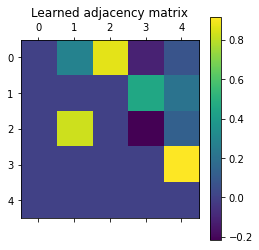

In [22]:
plt.matshow(output_dict['W'])
plt.title("Learned adjacency matrix")
plt.colorbar()

In [23]:
acyclic_W = notears.utils.threshold_output(output_dict['W'])

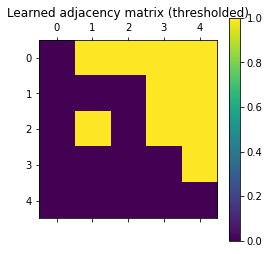

In [24]:
plt.matshow(acyclic_W)
plt.title("Learned adjacency matrix (thresholded)")
plt.colorbar()

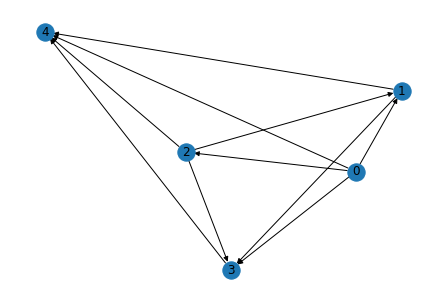

In [25]:
G = networkx.DiGraph(acyclic_W)
networkx.draw(G, with_labels=True)


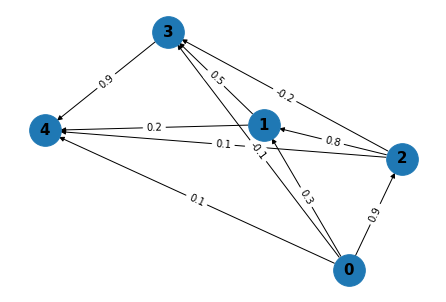

In [26]:
weighted_G = networkx.DiGraph((output_dict['W'] * acyclic_W).round(1))
layout = networkx.spring_layout(weighted_G)
networkx.draw(weighted_G, layout, node_size=1000, with_labels=True, font_weight='bold', font_size=15)
labels = networkx.get_edge_attributes(weighted_G,'weight')
networkx.draw_networkx_edge_labels(weighted_G,pos=layout,edge_labels=labels)
plt.show()

# Individual similarity analysis

In [15]:
ace_lst = [f'ace_{x}' for x in range(1,11)]
phq9_lst = [f'phq9_{x}' for x in range(1,11)]
gad_lst = [f'gad_{x}' for x in range(1,9)]
processed_individual_questions_df = pd.DataFrame(columns=['user_id'] + ace_lst + phq9_lst + gad_lst + promis_mental_lst + promis_physical_lst)

for uid in overall_df['user_id'].unique():
    each_df = overall_df.loc[overall_df['user_id']==uid]
    ace_sum = each_df[ace_lst].mean(axis=0)
    phq9_sum = each_df[phq9_lst].mean(axis=0)
    gad_sum = each_df[gad_lst].mean(axis=0)
    promis_mental_sum = promis_survey_processed.loc[promis_survey_processed['user_id']==uid][promis_mental_lst].mean(axis=0)
    promis_physical_sum = promis_survey_processed.loc[promis_survey_processed['user_id']==uid][promis_physical_lst].mean(axis=0)
    processed_individual_questions_df = processed_individual_questions_df.append(pd.DataFrame([[uid] + ace_sum.tolist() + phq9_sum.tolist() + gad_sum.tolist() + promis_mental_sum.tolist() + promis_physical_sum.tolist()], columns=['user_id'] + ace_lst + phq9_lst + gad_lst + promis_mental_lst + promis_physical_lst), ignore_index = True)


In [16]:
processed_individual_questions_df = processed_individual_questions_df.dropna()

In [17]:
len(processed_individual_questions_df.columns)

37

(250, 36)
Progress:	 h = 0.5207289788574698
		 loss = 1.447788131447549
		 a = 0.0
Increasing p:	 p =  1.00e+01
		 h_W_star = 0.112075915282972
Progress:	 h = 0.112075915282972
		 loss = 1.7910632886653073
		 a = 0.5207289788574698
Increasing p:	 p =  1.00e+02
		 h_W_star = 0.029482697988534312
Increasing p:	 p =  1.00e+03
		 h_W_star = 0.009661202829114757
Progress:	 h = 0.009661202829114757
		 loss = 2.1373834442879867
		 a = 1.6414881316871899
Increasing p:	 p =  1.00e+04
		 h_W_star = 0.0021839022152789767
Progress:	 h = 0.0021839022152789767
		 loss = 2.27219052645591
		 a = 11.302690960801947
Increasing p:	 p =  1.00e+05
		 h_W_star = 0.0006210578666241418
Increasing p:	 p =  1.00e+06
		 h_W_star = 0.00023587683836723272
Progress:	 h = 0.00023587683836723272
		 loss = 2.4106447690811357
		 a = 33.14171311359171
Increasing p:	 p =  1.00e+07
		 h_W_star = 7.511227502732254e-05
Increasing p:	 p =  1.00e+08
		 h_W_star = 2.8622389052657127e-05
Progress:	 h = 2.8622389052657127e-05
		

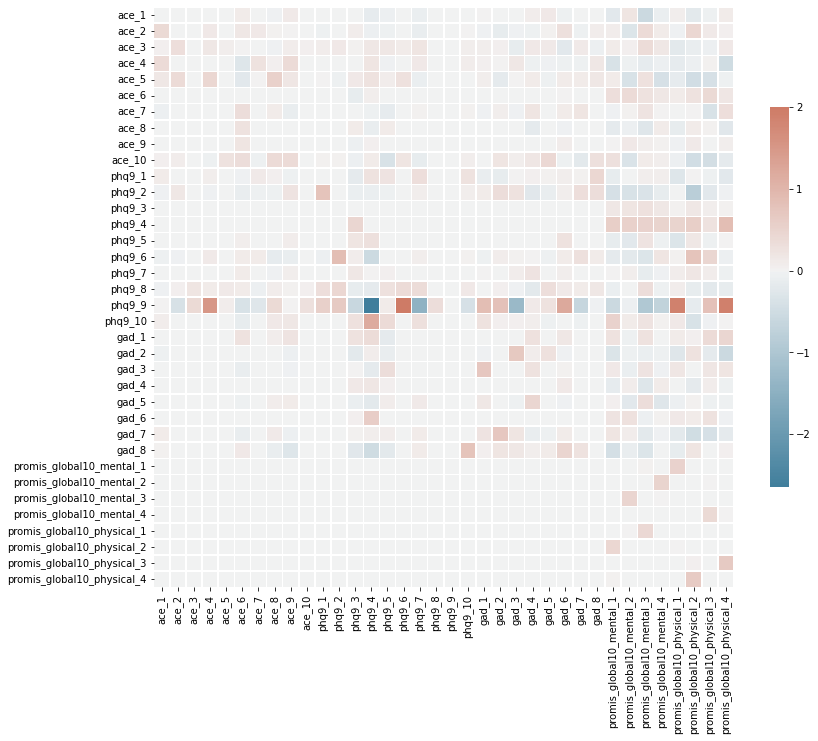

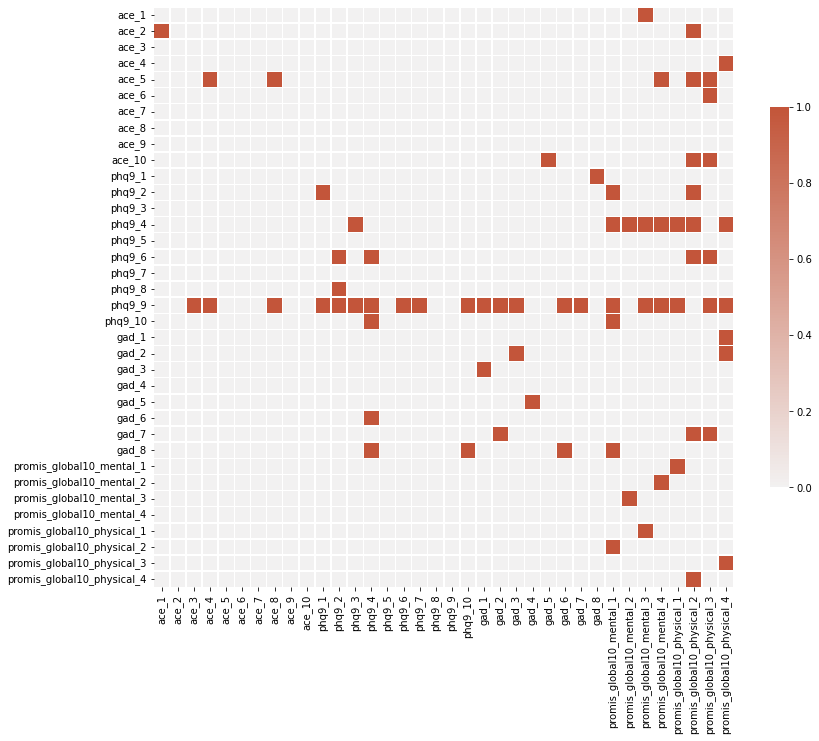

In [20]:
import numpy as np
import seaborn as sns
question_labels = ace_lst + phq9_lst + gad_lst + promis_mental_lst + promis_physical_lst

# for num in range(9, 0, -1):
num = 'total'
# randomly select 40 samples from the processed individual questions dataframe
data = processed_individual_questions_df[question_labels].to_numpy()
np.save(f'results/inputs/trial_{num}.npy', data)

print(data.shape)
output_dict = notears.run(notears.notears_standard, data.tolist(), notears.loss.least_squares_loss, notears.loss.least_squares_loss_grad, e=1e-8, verbose=True)
np.save(f'results/outputs/trial_{num}.npy', output_dict['W'])

acyclic_W = notears.utils.threshold_output(output_dict['W'])
np.save(f'results/threshold_outputs/trial_{num}.npy', acyclic_W)
print('Acyclicity loss: {}'.format(output_dict['h']))
print('Least squares loss: {}'.format(output_dict['loss']))

# save output matrice to results folder
f1, ax1 = plt.subplots(figsize=(13, 14))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(output_dict['W'], cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=question_labels, yticklabels=question_labels)
plt.savefig(f'results/diagrams/output_trial_{num}.png')

f2, ax2 = plt.subplots(figsize=(13, 14))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(acyclic_W, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=question_labels, yticklabels=question_labels)
plt.savefig(f'results/diagrams/threshold_output_trial_{num}.png')

In [30]:
data = processed_individual_questions_df[phq9_lst + gad_lst + promis_mental_lst + promis_physical_lst].sample(n=40).to_numpy().tolist()

In [32]:
output_dict = notears.run(notears.notears_standard, data, notears.loss.least_squares_loss, notears.loss.least_squares_loss_grad, e=1e-8, verbose=False)

In [22]:
print('Acyclicity loss: {}'.format(output_dict['h']))
print('Least squares loss: {}'.format(output_dict['loss']))

Acyclicity loss: 4.401245590202052e-09
Least squares loss: 0.5650673414085177


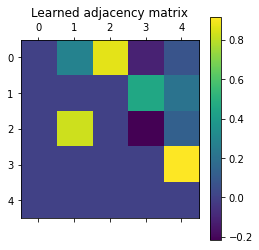

In [23]:
plt.matshow(output_dict['W'])
plt.title("Learned adjacency matrix")
plt.colorbar()

<AxesSubplot:>

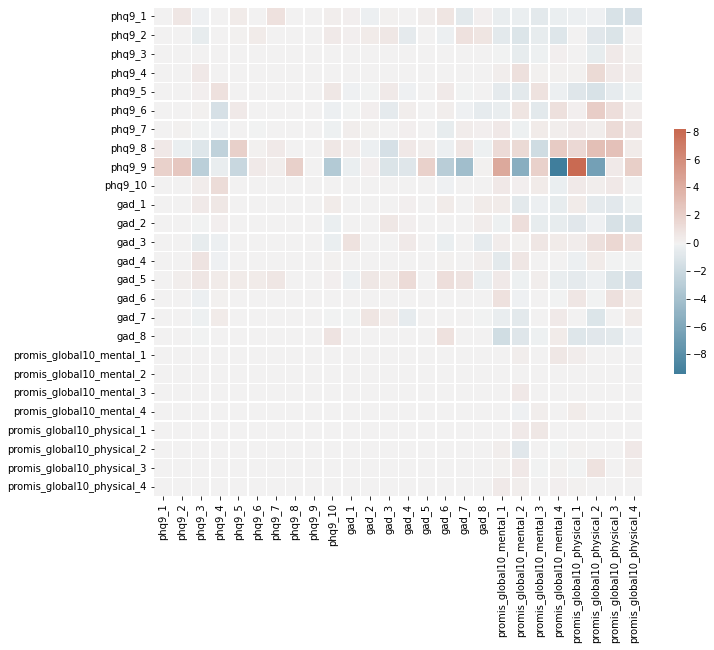

In [61]:
import seaborn as sns
question_labels = phq9_lst + gad_lst + promis_mental_lst + promis_physical_lst
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(output_dict['W'], cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=question_labels, yticklabels=question_labels)

In [63]:
acyclic_W = notears.utils.threshold_output(output_dict['W'])

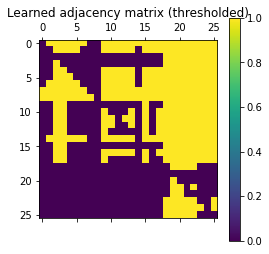

In [64]:
plt.matshow(acyclic_W)
plt.title("Learned adjacency matrix (thresholded)")
plt.colorbar()

<AxesSubplot:>

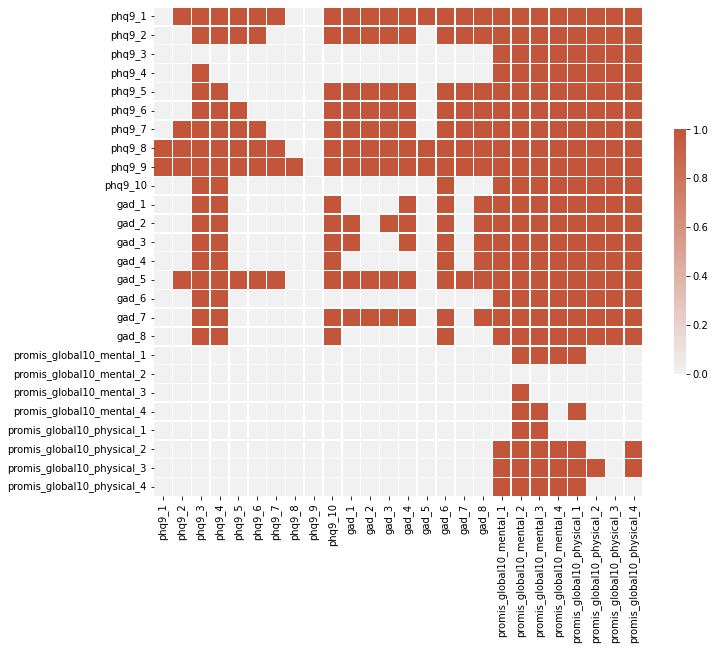

In [67]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(acyclic_W, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=question_labels, yticklabels=question_labels)

In [48]:
import numpy as np
np.unique(acyclic_W)

array([0., 1.])